# Description
Your task is to create a neural network to classify images in the cifar100 dataset.
- You have to write the code from scratch, train the model and test the accuracy on the test set.
- You are not allowed to use pretrained models to do this task.
- You have to submit the .ipynb files with the execution result.

# Grading criteria
- You are graded on the test set accuracy:
  - Test accuracy = 0.50, Grade = 6
  - Test accuracy = 0.55, Grade = 7
  - Test accuracy = 0.60, Grade = 8
  - Test accuracy = 0.65, Grade = 9
  - Test accuracy = 0.70, Grade = 10
- Plagiarism will automatically results in 0 mark.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import torch.nn.functional as F



In [4]:

# You are free to use any other kind of transforms here
mean = [0.5071, 0.4865, 0.4409]
std = [0.2009, 0.1984, 0.2023]

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33)),
    transforms.Normalize(mean, std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Datasets
train_set = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)


100%|██████████| 169M/169M [00:03<00:00, 48.6MB/s] 


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
print(len(train_set))
print(len(test_set))

50000
10000


# Resnet18

In [6]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet18(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def _make_layer(self, out_channels, blocks, stride):
        strides = [stride] + [1]*(blocks-1)
        layers = []
        for s in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).flatten(1)
        return self.fc(x)


In [7]:
# DO NOT MODIFY THIS CODE
def evaluate(net: nn.Module,
             data) -> float:
  """
  Evaluates the neural network on the given data.
  @param net: the neural network to evaluate
  @param data: the data to evaluate on
  @return: the accuracy of the neural network on the given data
  """
  data_loader = torch.utils.data.DataLoader(data,
                                            batch_size=100,
                                            shuffle=False)

  correct = 0
  total = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  net.to(device)
  net.eval()
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(data_loader):
      inputs, targets = inputs.to(device), targets.to(device)
      pred_target = net(inputs).argmax(dim=1)
      correct += (pred_target == targets).sum().item()
      total += targets.size(0)

  return correct / total

In [8]:
def train(model, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    train_losses = []
    train_accs = []

    for epoch in tqdm(range(EPOCHS), desc="Training"):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = out.max(1)
            total += y.size(0)
            correct += predicted.eq(y).sum().item()
        
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        print(f"Epoch {epoch+1}/{EPOCHS}: "
              f"Train Loss: {epoch_loss:.4f} | "
              f"Train Acc: {epoch_acc:.4f}")

    return train_accs, train_losses

In [9]:
LEARNING_RATE = 0.001
EPOCHS = 100
PATIENCE = 10
BATCH_SIZE = 64
WEIGHT_DECAY = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = ResNet18().to(device)
train_accuracies, train_losses = train(net, train_loader)

cifar100_test = test_set

Training:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100: Train Loss: 4.1043 | Train Acc: 0.0690
Epoch 2/100: Train Loss: 3.5388 | Train Acc: 0.1497
Epoch 3/100: Train Loss: 3.0929 | Train Acc: 0.2275
Epoch 4/100: Train Loss: 2.7406 | Train Acc: 0.2961
Epoch 5/100: Train Loss: 2.4436 | Train Acc: 0.3557
Epoch 6/100: Train Loss: 2.2349 | Train Acc: 0.4045
Epoch 7/100: Train Loss: 2.0654 | Train Acc: 0.4389
Epoch 8/100: Train Loss: 1.9123 | Train Acc: 0.4773
Epoch 9/100: Train Loss: 1.7910 | Train Acc: 0.5068
Epoch 10/100: Train Loss: 1.6859 | Train Acc: 0.5313
Epoch 11/100: Train Loss: 1.5910 | Train Acc: 0.5513
Epoch 12/100: Train Loss: 1.4966 | Train Acc: 0.5744
Epoch 13/100: Train Loss: 1.4236 | Train Acc: 0.5919
Epoch 14/100: Train Loss: 1.3547 | Train Acc: 0.6135
Epoch 15/100: Train Loss: 1.2914 | Train Acc: 0.6272
Epoch 16/100: Train Loss: 1.2333 | Train Acc: 0.6415
Epoch 17/100: Train Loss: 1.1659 | Train Acc: 0.6596
Epoch 18/100: Train Loss: 1.1129 | Train Acc: 0.6714
Epoch 19/100: Train Loss: 1.0591 | Train Acc: 0.6883
Ep

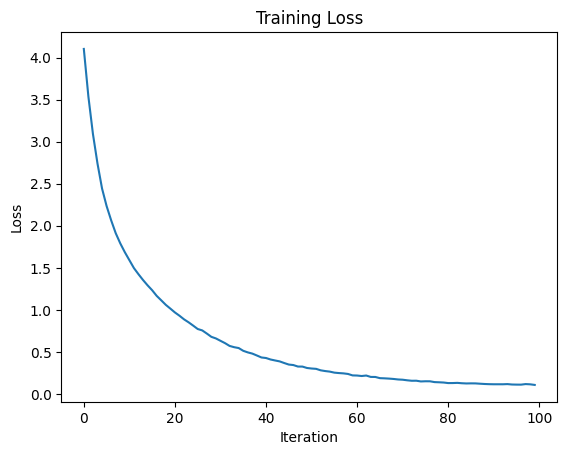

In [10]:
# DO NOT MODIFY THIS CODE
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

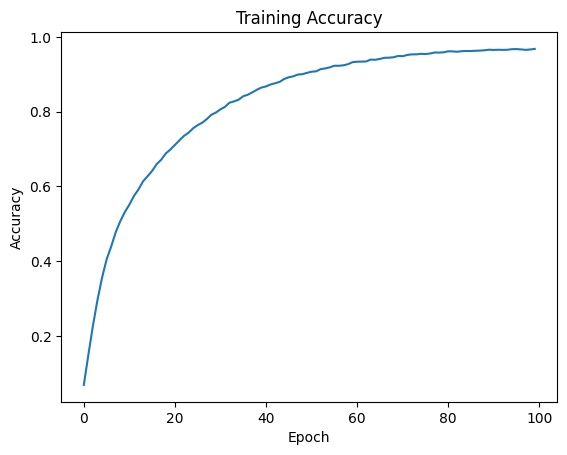

In [11]:
# DO NOT MODIFY THIS CODE
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [12]:
# DO NOT MODIFY THIS CODE
test_accuracy = evaluate(net, cifar100_test)
print(f"Test accuracy: {test_accuracy}")



Test accuracy: 0.74
